# parcels regions

runs parcels on existing netcdf files

In [1]:
%matplotlib inline

In [2]:
import math
import os
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from parcels import FieldSet, ParticleSet
from parcels import AdvectionRK4
from datetime import timedelta, datetime

# it got annoying
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
DATA_6KM = 6
DATA_2KM = 2
DATA_1KM = 1

filename_dict = {
    DATA_6KM: "west_coast_6km_hourly",
    DATA_2KM: "west_coast_2km_hourly",
    DATA_1KM: "west_coast_1km_hourly"
}

def get_file_info(name, path, res):
    xrds = xr.open_dataset(path)
    # spherical mesh
    fs = FieldSet.from_xarray_dataset(
            xrds.copy(deep=True),
            dict(U="u",V="v"),
            dict(lat="lat",lon="lon",time="time"),
        )
    xrds.close()
    lat = xrds["lat"].values
    lon = xrds["lon"].values
    return dict(
        name = name,
        path = path,
        res = res,
        xrds = xrds,
        fs = fs,
        timerng = (xrds["time"].min().values, xrds["time"].max().values),
        timerng_secs = fs.gridset.dimrange("time"),
        lat = lat,
        lon = lon,
        domain = {
            "S": lat.min(),
            "N": lat.max(),
            "W": lon.min(),
            "E": lon.max(),
        }
    )

### netcdf files

due to the lack of unique configurations for each file, there are limitations
- must have same time domain
- a domain that contains the defined spawn points later in the notebook

In [4]:
files = [
    get_file_info("tijuana_lin", "west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river_lin.nc", DATA_1KM),
    get_file_info("tijuana_invdist", "west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river_invdist.nc", DATA_1KM),
]

## Animated gif stuff and particle simulation

runs on each file you give it

In [5]:
# animation man very cool
# reference tutorial_Agulhasparticles
# needs ErrorCode for particle recovery
from operator import attrgetter
from parcels import ErrorCode, JITParticle, Variable

max_v = 1.1 # for display purposes only, so the vector field colors don't change every iteration

class TimedParticle(JITParticle):
    lifetime = Variable("lifetime", initial=0, dtype=np.float32)
    spawntime = Variable("spawntime", initial=attrgetter("time"), dtype=np.float32)
    
def ParticleLifetime(particle, fieldset, time):
    particle.lifetime += particle.dt

def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
def exec_save_pset(data, i, runtime, dt, zpad = 3, save_snapshot = True, exec_pset = True):
    """
    Saves a snapshot of a particle simulation and then executes.
    
    Args:
        data (dict)
        i (int)
        runtime (float): seconds
        dt (float): seconds
    """
    if save_snapshot:
        data["pset"].show(savefile=str(data["snap_path"])+"/particles"+str(i).zfill(zpad), field="vector", vmax=max_v)
    
    if exec_pset:
        # temporary - TODO make it only init once
        k_plifetime = data["pset"].Kernel(ParticleLifetime)

        data["pset"].execute(
            AdvectionRK4 + k_plifetime,
            runtime=timedelta(seconds=runtime),
            dt=timedelta(seconds=dt),
            recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
            output_file=data["pfile"]
        )

### set up particle spawn points

currently works where particles are generated at random positions with a bit of variations, and are released at set intervals.

note about interpolation methods: only `linear` works if you want to use the FieldSet in a ParticleSet.

TODO move simulation configurations somewhere else so its unique for every dataset

move it all into json config shenanigans

In [6]:
repeat_dt = timedelta(hours=4) # interval at which particles are released
particles_per_dt = 10 # number of particles to release at each interval
max_variation = 0.0015 # the max degrees a particle can be away from a spawn point

# TODO: spawn points should probably be saved with a netcdf file
spawn_points = np.array([
#     (32.551707, -117.136)
    (32.551707, -117.138),
    (32.557, -117.138)
])

In [7]:
# NOTE same spawns for every dataset currently

# path for saving particle trajectories and data
part_path = Path("particledata")
part_path.mkdir(parents=True, exist_ok=True)

for f in files:
    repetitions = math.floor(f["timerng_secs"][1] / repeat_dt.total_seconds())
    total = repetitions * particles_per_dt
    lat_arr = np.zeros(total)
    lon_arr = np.zeros(total)
    time_arr = np.zeros(total)
    for i in range(repetitions):
        time_arr[particles_per_dt * i:particles_per_dt * (i + 1)] = repeat_dt.seconds * i

    sp_lat = spawn_points.T[0][np.random.randint(0, len(spawn_points), total)]
    sp_lon = spawn_points.T[1][np.random.randint(0, len(spawn_points), total)]
    variances_lat = (np.random.random(total) * 2 - 1) * max_variation
    variances_lon = (np.random.random(total) * 2 - 1) * max_variation

    p_lats = sp_lat + variances_lat
    p_lons = sp_lon + variances_lon

    f["pset"] = ParticleSet(fieldset=f["fs"], pclass=TimedParticle, lon=p_lons, lat=p_lats, time=time_arr)
    save_path = f"{part_path}/particle_{f['name']}.nc"
    f["pfile"] = f["pset"].ParticleFile(save_path)
    print(f"Particle trajectories for {f['name']} will be saved to {save_path}")

Particle trajectories for tijuana_lin will be saved to particledata/particle_tijuana_lin.nc
Particle trajectories for tijuana_invdist will be saved to particledata/particle_tijuana_invdist.nc


/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


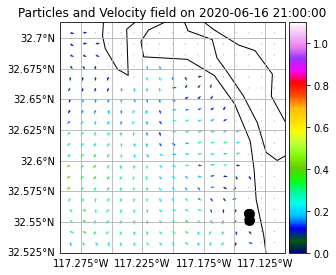

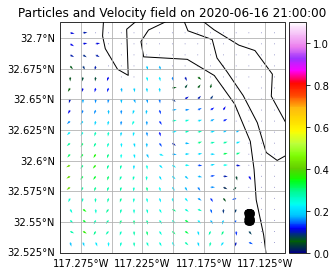

[None, None]

In [8]:
[f["pset"].show(field="vector", vmax=max_v) for f in files]

### setting up particle execution

there are a few things to configure before actually executing the simulation

configure `snapshot_interval`, `p_dt`, `clear_directories`, and `save_snap` to your needs

In [9]:
snapshot_interval = 3600 * 3 # seconds, determines how often to take a snapshot of the simulation
p_dt = 300 # seconds, determines the dt of the simulation itself (does not impact snapshot interval)

clear_directories = True # whether to clear the directory the snapshots will be saved in
save_snap = False # whether to save snapshots of the simulation for gif generation later

for f in files:
    f["snap_num"] = math.floor((f["timerng_secs"][1] - f["timerng_secs"][0]) / snapshot_interval)
    f["last_int"] = f["timerng_secs"][1] - f["snap_num"] * snapshot_interval
    if f["last_int"] == 0:
        print(f"Num snapshots to save for {f['path']}: {f['snap_num'] + 1}")
    else:
        print(f"Num snapshots to save for {f['path']}: {f['snap_num'] + 2}")
    f["snap_path"] = Path(f"snapshots_{filename_dict[f['res']]}/{f['name']}")
    f["snap_path"].mkdir(parents=True, exist_ok=True)
    print(f"Path to save snapshots to: {f['snap_path']}")
    # only clear directory if desired or actually saving images
    if clear_directories and save_snap:
        for p in f["snap_path"].glob("*.png"):
            p.unlink()

Num snapshots to save for west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river_lin.nc: 57
Path to save snapshots to: snapshots_west_coast_1km_hourly/tijuana_lin
Num snapshots to save for west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river_invdist.nc: 57
Path to save snapshots to: snapshots_west_coast_1km_hourly/tijuana_invdist


In [10]:
for f in files:
    for i in range(f["snap_num"]):
        exec_save_pset(f, i, snapshot_interval, p_dt, save_snapshot=save_snap)

    # save the second-to-last frame
    exec_save_pset(f, f["snap_num"], 0, 0, save_snapshot=save_snap, exec_pset=False)

    # run the last interval (the remainder) if needed
    if f["last_int"] != 0:
        exec_save_pset(f, f["snap_num"] + 1, f["last_int"], p_dt, save_snapshot=save_snap)
        
    f["pfile"].export()

print("all simulations done and snapshots saved (if simulation was saving snapshots)")

INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/6cffa1346dd65935e2a5c1aa029e65c2_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/4b6847d0b0602534ea73e5a87bab28c1_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/ab297436888888db297aa2bf9f488f01_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/983c249422a9ce269a4153aa3a46e88c_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/90d7d1dd80409027687e9ac4d3ab7b32_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/d37bfa1d455d05517650008cf1472621_0.so
INFO: Compiled TimedParticleAdvectionRK4

INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/ed055a5e200d52b86a79c0870bb022e4_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/1f9b373369fe21a58c2b4e7e1e9d347f_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/112d4a99f65e8c8cf7b2ff52feecd945_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/5c357a58c3de05fdf29ab3edc7bc8233_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/1796b82952d78a4a419de7a9a8891224_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/c8aace30a4607dfba42fa3ae0fd9a772_0.so
INFO: Compiled TimedParticleAdvectionRK4

INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/81c9a3a58f5fc5d87e164d41c8027f70_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/48172aae910cffd354eca1703f5f010b_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/af547513e04bceaa006910653c44d1a5_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/9947d9ff05f9f1c3fb156e674fa98ff7_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/1216f2ed575cfd3028ac7279294970a1_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/6bb67680ee53098cfef0fb5908bba413_0.so
INFO: Compiled TimedParticleAdvectionRK4

all simulations done and snapshots saved (if simulation was saving snapshots)


### gif generation

don't have to run, requires [magick](https://imagemagick.org/index.php)

the gifs will be saved `snapshots_west_coast_xkm_hourly/` where xkm is the resolution

In [11]:
import subprocess

gif_delay = 25 # ms

if save_snap:
    for f in files:
        magick_sp = subprocess.Popen(["magick", "-delay", str(gif_delay), str(f["snap_path"]) + "/*.png", f"snapshots_{filename_dict[f['res']]}/partsim_{f['name']}.gif"], 
                                       stdout=subprocess.PIPE,
                                       stderr=subprocess.PIPE,
                                       universal_newlines=True)
        stdout, stderr = magick_sp.communicate()
        print((stdout, stderr))